# Observation Targets Assessor
This notebook aims to injest a list of source descriptions and observation criteria from the STM effort, applying appropriate metric tools to assess against the critera for a list of mission concept descriptions.

To run this on Google Colab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnGBaker/GWI-metrics/blob/main/Notebooks/ObservationTargetsAssessor.ipynb)

### Some basic setup

In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/JohnGBaker/GWI-metrics.git
    src='GWI-metrics/src/'
else:
    src='../src/'
!mkdir -p '../plots/'

# Import
import os
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(src)
import constants
import metrics
import sources
import concepts
import subsystems
import background
import pandas as pd
from glob import glob
import re
from astropy.coordinates import Angle
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u

### Define the set of concepts
Here we load in a set of the pre-defined concepts, or you can define your own

In [2]:
missionNames = (
    'LISACBE',
    'LISASciRDv1',
    'TwinLISA',
    'LISAGrande',
    'LISAU',
    'GoBIGLISA',
    'ALIA',
    'ALIAlowL')
missions=[concepts.menu[mission] for mission in missionNames]

for mission in missions:
    mission=background.add2model(mission)
#model = concepts.LISACBE.copy()
#modelName = model.get('label')
#model = background.add2model(model)     # add galactic background model

### Load the observation target data
Load information about the target sources and the observation quality targets from the STM.
The data are from https://nasa.sharepoint.com/:x:/t/GravitationalWaveImager/EaaeMC7L-2NJpFCQloYbSnoBDZag_cvFWR5_BjRoFAD6Tw?e=uWr4mU

In [3]:
datadir='../Data/'
files=glob(datadir+'ObservationObjectives*.csv')
files.sort(key=os.path.getmtime)
print('Observation targets files are:',files)
file=files[-1]
print('Observation targets file is:',file)
#Read file
df=pd.read_csv(file,header=1)
print(len(df),'rows read from file.')
if True:
    #Drop empty rows
    for i,row in df.iterrows():
        if row.isnull().all():
            df=df.drop(i)
    #Fill empties in first column with values above
    val=float('nan')
    col='Source class'
    for i,row in df.iterrows():
        if row.isnull()[col]:
            df.loc[i,col]=val
        else:
            val=df.loc[i,col]
#Drop rows without a labeled objective
for i,row in df.iterrows():
    if row.isnull()['provisional POC label']:
        df=df.drop(i)
print(len(df),'rows with a potential observation label.')
#Fill empties with value above
if True:
    for columnName, columnData in df.iteritems():
        val=float('nan')
        nulls=columnData.isnull()
        for i,row in df.iterrows():
            if nulls[i]:
                df.loc[i,columnName]=val
            else:
                val=df.loc[i,columnName]
#derive masses
if True:
    col=2
    df['m1']=float('nan')
    df['m2']=float('nan')
    for i,row in df.iterrows():
        txt=row.iloc[col]
        mtxt=re.search('\s*Msun\s*\+\s*.*Msun',txt)
        #print('::',mtxt)
        mtxt=re.search('(\d+\.*\d*[eE]*[\+-]*\d*)\s*M[Ss]un\s*\+\s*(\d+\.*\d*[eE]*[\+-]*\d*)\s*M[Ss]un',txt)
        #print(':',mtxt)
        m1=None
        if mtxt is not None: 
            try:
                m1=float(mtxt[1])
                #print(m1)
                m2=float(mtxt[2])
                #print(m2)
            except: 
                pass
        if m1 is None:
            df=df.drop(i)
        else:
            df.loc[i,'m1']=m1
            df.loc[i,'m2']=m2
    print(len(df),'rows with masses.')
#derive redshifts/distances
if True:
    col=3
    df['z']=float('nan')
    df['dist']=float('nan')
    for i,row in df.iterrows():
        txt=row.iloc[col]
        ztxt=re.search('z\s*=\s*(\d+\.*\d*[eE]*[\+-]*\d*)',txt)
        z=None
        if ztxt is not None: 
            try:
                z=float(ztxt[1])
                dist=cosmo.luminosity_distance(z).to(u.kpc).value
            except: 
                pass
        if z is None:
            df=df.drop(i)
        else:
            df.loc[i,'z']=z
            df.loc[i,'dist']=dist
    print(len(df),'rows with redshift.')
#derive timecuts
if True:
    col=4
    df['timecut']=float('nan')
    for i,row in df.iterrows():
        txt=row.iloc[col]
        ztxt=re.search('(.*)\s+(before|<)\s+merger',txt)
        z=None
        if ztxt is not None:
            try:
                ztxt=ztxt[1]
                if ztxt=='month to week': z=15
                elif ztxt=='year to month': z=180
            except: 
                pass
        df.loc[i,'timecut']=z
#derive SNRs
if True:
    col=4
    df['SNR']=float('nan')
    for i,row in df.iterrows():
        txt=row.iloc[col]
        ztxt=re.search('SNR\s*=\s*(\d+\.*\d*[eE]*[\+-]*\d*)',txt)
        z=None
        if ztxt is not None: 
            try:
                z=float(ztxt[1])
            except: 
                pass
        df.loc[i,'SNR']=z
#prep CW sources
if True:
    col=0
    df['CW']=False
    df['f0']=float('nan')
    for i,row in df.iterrows():
        txt=row.iloc[col]
        if 'Persistent' in txt: 
            df.loc[i,'CW']=True
            #Also need to f0 (or separation)
            txt=row['freq']
            try:
                ftxt=re.search('(\d+\.*\d*[eE]*[\+-]*\d*)\s+Hz',txt)[1]
                f0=float(ftxt)
                df.loc[i,'f0']=f0
            except:
                print('Failed to get freq from txt "'+txt+'"')
                df=df.drop(i)
#process angular precision
if True:
    col=6
    df['resolution']=float('nan')
    for i,row in df.iterrows():
        txt=row.iloc[col]
        z=None
        #print(txt)
        try:
            #print(Angle(txt))
            z=Angle(txt).arcsecond
        except: 
            pass
        df.loc[i,'resolution']=z
#Drop cases with neither angular precision requirement nor SNR
for i,row in df.iterrows():
    if np.isnan(row['resolution']) and np.isnan(row['SNR']):df=df.drop(i)
print(len(df),'rows with constraints.')        
display(df)

    

Observation targets files are: ['../Data/ObservationObjectives-9-May-22.csv', '../Data/ObservationObjectives-21-Jun-22.csv', '../Data/ObservationObjectives-09-09-22.csv', '../Data/ObservationObjectives-15-Jul-22.csv']
Observation targets file is: ../Data/ObservationObjectives-15-Jul-22.csv
131 rows read from file.
77 rows with a potential observation label.
74 rows with masses.
71 rows with redshift.
66 rows with constraints.


,Source class,Source label,Source specification,Distance/redshift (dL in kpc),Sub-specs,freq,Required precision,provisional POC label,Achievable by Concept X?,science motivation,sci ref,m1,m2,z,dist,timecut,SNR,CW,f0,resolution
1,1. Stellar-scale mergers,NS binary,1.5 MSun + 1.5 MSun,z = 0.05; dL = 2.30e5,month to week before merger,0.5 Hz,1 arcmin,1.1.b,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,1.5,1.5,0.05,2.245822e+05,15.0,NaN,False,NaN,60.0
2,1. Stellar-scale mergers,NS binary,1.5 MSun + 1.5 MSun,z = 1.0; dL = 6.79e6,chirping,0.5 Hz,30 arcsec,1.1.c,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,1.5,1.5,1.00,6.726141e+06,NaN,NaN,False,NaN,30.0
3,1. Stellar-scale mergers,NS binary,1.5 MSun + 1.5 MSun,z = 20; dL = 2.31e8,chirping,0.5 Hz,6 arcsec,1.1.d,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,1.5,1.5,20.00,2.316106e+08,NaN,NaN,False,NaN,6.0
4,1. Stellar-scale mergers,NS binary,1.5 MSun + 1.5 MSun,z = 10; dL = 1.07e8,chirping,0.5 Hz,1 arcsec,1.1.e,NaN,standard sirens for cosmological structure; fo...,Sedda et al. and Dvorkin et al.,1.5,1.5,10.00,1.065544e+08,NaN,NaN,False,NaN,1.0
5,1. Stellar-scale mergers,NS binary,1.5 MSun + 1.5 MSun,z = 0.15; dL = 6.0e5,days before merger,0.5 Hz,1 deg,1.1.f,NaN,H0 measurements using joint GW-EM detections o...,https://arxiv.org/pdf/2011.01211.pdf,1.5,1.5,0.15,7.212455e+05,NaN,NaN,False,NaN,3600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,5. IMRI,IMBH + WD,10^3 MSun + 0.8 Msun,z = 1.0; dL = 6.79e6,no particular timescale,0.01-1 Hz (ish),10 arcmin,5.5.c,NaN,H0 measurements associating GW sources with ho...,https://arxiv.org/pdf/2011.01211.pdf,3.0,0.8,1.00,6.726141e+06,NaN,NaN,False,NaN,600.0
80,5. IMRI,IMBH + SOBH,5e3 Msun + 1 Msun,z = 0.3; dL = 1.57e6,SNR = 50,0.01-1 Hz (ish),10 arcmin,5.6.a,NaN,H0 measurements associating GW sources with ho...,https://arxiv.org/pdf/2011.01211.pdf,5000.0,1.0,0.30,1.572542e+06,NaN,50.0,False,NaN,600.0
81,5. IMRI,IMBH + SOBH,5e3 Msun + 1 Msun,z = 1.0; dL = 6.79e6,no particular timescale,0.01-1 Hz (ish),10 arcmin,5.6.b,NaN,H0 measurements associating GW sources with ho...,https://arxiv.org/pdf/2011.01211.pdf,5000.0,1.0,1.00,6.726141e+06,NaN,NaN,False,NaN,600.0
82,5. IMRI,MBH + IMBH,1e6 MSun + 1e3 MSun,z = 5.5; dL = 5.33e7,SNR = 20,0.01-1 Hz (ish),10 arcmin,5.7.a,NaN,H0 measurements associating GW sources with ho...,https://arxiv.org/pdf/2011.01211.pdf,1000000.0,1000.0,5.50,5.346936e+07,NaN,20.0,False,NaN,600.0


In [4]:
# make source dictionaries
objectiveList=[]
minimumSNR=5
for i,row in df.iterrows():
    obj={}
    obj['label']=row['provisional POC label']
    obj['m1']=row['m1']*(1+row['z'])#convert to redshifted mass
    obj['m2']=row['m2']*(1+row['z'])#convert to redshifted mass
    dist=cosmo.luminosity_distance(row['z']).to(u.kpc).value
    obj['dl']=dist
    if row['CW']:
        obj['type']='CW'
        obj['f0']=row['f0']
    else:
        obj['type']='chirp'
        if np.isfinite(row['timecut']):
            obj['timecut']=row['timecut']
    #Now add the conditions
    conditions={}
    if np.isfinite(row['resolution']):
        conditions['resolution']=row['resolution']/3600/180*np.pi #convert arcsec to rad
    snr=minimumSNR
    if np.isfinite(row['SNR']): snr=max([minimumSNR,row['SNR']])
    conditions['SNR']=snr
    obj['conditions']=conditions
    objectiveList.append(obj)
    

### Perform the observations and assessment
We first compute the SNR and then the angular resolution

In [5]:
import importlib
importlib.reload(metrics)
importlib.reload(sources)
addOldRes=False
for mission in missions:
    print('\nProcessing mission',mission['label'],'\n')
    obs_versions=[]
    if addOldRes: versions=[False,True]
    else: versions=[False]
    for useOldRes in versions:
        obs = list()
        for s in objectiveList:
            print('\nProcessing:',s.get('label','--unnamed--'))
            print(s)
            if useOldRes:
                sgn=-1;
                if s['type']=='CW': sgn=1 #There is currently a pathology with getSourceSnr, it needs T>0 for CW and T<0 for chirp
                ob = metrics.getSourceSnr(s,mission,sgn*4.0*constants.year)
                ob = metrics.getResolution(ob)
            else:
                #print('OLD')
                #ob = metrics.getSourceSnr(s,mission,-4.0*constants.year)
                #print('NEW')
                ob = metrics.getSNRandSkyResolution(s,mission,Tmax=4)
            print('SNR,res',ob['SNR'],ob['Angular Resolution'])
            #Perform the assessment
            #The assessment is based on the ratio of the estimated capability to the objective for each of
            #resolution and SNR, with <=1 meaning that the objective is met
            #A total is based on the worst of those present
            conditions=s['conditions']
            assessment={}
            alleps=[]
            print(conditions)
            if 'SNR' in conditions:
                #eps=ob['SNR']/conditions['SNR']
                eps=conditions['SNR']/ob['SNR']
                assessment['eps_SNR']=eps
                alleps.append(eps)
            if 'resolution' in conditions:
                #eps=conditions['resolution']/ob['Angular Resolution']
                eps=ob['Angular Resolution']/conditions['resolution']
                #print(ob['Angular Resolution'][-1],conditions['resolution'],eps)
                assessment['eps_res']=eps
                alleps.append(eps)
            #print('alleps',alleps)
            if len(alleps)>0: 
                assessment['eps']=max(alleps)*(1+sum(alleps)*0) #The last factor ensures that NANs stay NANs
            ob['assessment']=assessment    
            print(assessment)
            obs.append(ob)
        obs_versions.append(obs)
        
    mission['obs']=obs_versions[0]
    if addOldRes:mission['obs_old']=obs_versions[1]




Processing mission LISA(CBE) 


Processing: 1.1.b
{'label': '1.1.b', 'm1': 1.5750000000000002, 'm2': 1.5750000000000002, 'dl': 224582.2244309782, 'type': 'chirp', 'timecut': 15.0, 'conditions': {'resolution': 0.0002908882086657216, 'SNR': 5}}
rough tstart = -126232599.05418241 0.1106704277470008 < f < 4957.7802371184
ncut= 23 n= 977
tstart = -126232599.05418241 t[0]= -129649087.31673475 0.14161770601131066 < f < 4957.7802371184
Recomputing chirp because net resolution is low. 1 < 500.0
rough tstart = -126232599.05418241 0.1106704277470008 < f < 0.17173053372984912
ncut= 583 n= 417
tstart = -126232599.05418241 t[0]= -126274343.9011725 0.14301731930682696 < f < 0.17173053372984912
SNR,res 0.0009701815680158133 nan
{'resolution': 0.0002908882086657216, 'SNR': 5}
{'eps_SNR': 5153.674492317817, 'eps_res': nan, 'eps': nan}

Processing: 1.1.c
{'label': '1.1.c', 'm1': 3.0, 'm2': 3.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 0.0001454441043328608, 'SNR': 5}}
rough

tstart = -126232599.05418241 t[0]= -126320895.34684008 1.9168116314601475e-05 < f < 2.3075470209269618e-05
SNR,res 0.010755462166313947 nan
{'resolution': 4.84813681109536e-06, 'SNR': 5}
{'eps_SNR': 464.8800695575848, 'eps_res': nan, 'eps': nan}

Processing: 2.1.b
{'label': '2.1.b', 'm1': 2000000.0, 'm2': 2000000.0, 'dl': 6726141.242139786, 'type': 'chirp', 'timecut': 180.0, 'conditions': {'resolution': 0.0002908882086657216, 'SNR': 5}}
rough tstart = -126232599.05418241 1.7063120383781664e-05 < f < 0.003904251936730741
ncut= 21 n= 979
tstart = -126232599.05418241 t[0]= -127075144.8242819 1.912745198577301e-05 < f < 0.003904251936730741
Recomputing chirp because net resolution is low. 1 < 500.0
rough tstart = -126232599.05418241 1.7063120383781664e-05 < f < 2.3075470209269618e-05
ncut= 385 n= 615
tstart = -126232599.05418241 t[0]= -126320895.34684008 1.9168116314601475e-05 < f < 2.3075470209269618e-05
SNR,res 0.010755462166313947 nan
{'resolution': 0.0002908882086657216, 'SNR': 5}
{'ep

/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:568: RuntimeWarning: invalid value encountered in double_scalars
  sig2=1/fac/(I22-I12**2/I11)
/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:618: RuntimeWarning: divide by zero encountered in double_scalars
  return 4/rho2om2/Dsep**2


ncut= 114 n= 886
tstart = -126232599.05418241 t[0]= -126608744.41250348 0.0005068595621925716 < f < 0.0012043583593988531
SNR,res 1.8962915061037537 0.32613758032702783
{'resolution': 2.9088820866572157e-05, 'SNR': 100.0}
{'eps_SNR': 52.73450821148624, 'eps_res': 11211.784136008537, 'eps': 11211.784136008537}

Processing: 3.3.e
{'label': '3.3.e', 'm1': 110.0, 'm2': 5500000.0, 'dl': 106554395.34780096, 'type': 'chirp', 'conditions': {'resolution': 2.9088820866572157e-05, 'SNR': 100.0}}
rough tstart = -126232599.05418241 0.0003350182231131346 < f < 0.0008321021392210259
ncut= 155 n= 845
tstart = -126232599.05418241 t[0]= -126520674.34762096 0.00038580824636269627 < f < 0.0008321021392210259
SNR,res 0.8934945538442793 0.9158749978915002
{'resolution': 2.9088820866572157e-05, 'SNR': 100.0}
{'eps_SNR': 111.92010020626077, 'eps_res': 31485.46316444168, 'eps': 31485.46316444168}

Processing: 3.3.f
{'label': '3.3.f', 'm1': 20.0, 'm2': 1000000.0, 'dl': 6726141.242139786, 'type': 'chirp', 'condi

tstart = -126232599.05418241 t[0]= -127101496.23456495 0.0046485209676549455 < f < 1.7342426561024087
SNR,res 11.072427936953165 0.004100543240358689
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 0.4515721419430494, 'eps_res': 1.4096629283007096, 'eps': 1.4096629283007096}

Processing: 5.3.a
{'label': '5.3.a', 'm1': 3000.0, 'm2': 300.0, 'dl': 15875191.123148063, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'SNR': 5}}
rough tstart = -126232599.05418241 0.0021745237810233023 < f < 3.2202326902003318
ncut= 47 n= 953
tstart = -126232599.05418241 t[0]= -128802248.35596132 0.0030656876947195827 < f < 3.2202326902003318
SNR,res 9.885689649814358 0.006418215208825516
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 0.5057816072643848, 'eps_res': 2.2064198608342704, 'eps': 2.2064198608342704}

Processing: 5.3.b
{'label': '5.3.b', 'm1': 9000.0, 'm2': 900.0, 'dl': 82565701.74638993, 'type': 'chirp', 'conditions': {'resolution': 0.002908882086657215

/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:618: RuntimeWarning: divide by zero encountered in true_divide
  return 4/rho2om2/Dsep**2
/Users/jgbaker/Projects/FGRST/GWImager/GWI-metrics/Notebooks/../src/metrics.py:568: RuntimeWarning: divide by zero encountered in double_scalars
  sig2=1/fac/(I22-I12**2/I11)


ncut= 24 n= 976
tstart = -126232599.05418241 t[0]= -127425588.91953753 0.09514379855315429 < f < 2602.83462448716
SNR,res 0.003010620599824864 0.9792567033587475
{'resolution': 4.84813681109536e-06, 'SNR': 5}
{'eps_SNR': 1660.7871481019108, 'eps_res': 201986.19418446237, 'eps': 201986.19418446237}

Processing: 1.1.h
{'label': '1.1.h', 'm1': 3.0, 'm2': 3.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 0.0002908882086657216, 'SNR': 5}}
rough tstart = -126232599.05418241 0.07398784839643943 < f < 2602.83462448716
ncut= 24 n= 976
tstart = -126232599.05418241 t[0]= -127425588.91953753 0.09514379855315429 < f < 2602.83462448716
SNR,res 0.003010620599824864 0.9792567033587475
{'resolution': 0.0002908882086657216, 'SNR': 5}
{'eps_SNR': 1660.7871481019108, 'eps_res': 3366.4365697410394, 'eps': 3366.4365697410394}

Processing: 1.1.i
{'label': '1.1.i', 'm1': 3.0, 'm2': 3.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 0.017453292519943295, 'SNR'

SNR,res 10019.487997006212 0.0013174238571510967
{'resolution': 4.84813681109536e-06, 'SNR': 5}
{'eps_SNR': 0.0004990274953664282, 'eps_res': 271.73817664057333, 'eps': 271.73817664057333}

Processing: 2.2.b
{'label': '2.2.b', 'm1': 1500000.0, 'm2': 1500000.0, 'dl': 15875191.123148063, 'type': 'chirp', 'conditions': {'resolution': 0.0002908882086657216, 'SNR': 5}}
rough tstart = -126232599.05418241 2.041990409488994e-05 < f < 0.005205669248974321
ncut= 22 n= 978
tstart = -126232599.05418241 t[0]= -126238887.01450107 2.3070021301879525e-05 < f < 0.005205669248974321
SNR,res 3831.947700471268 0.0027930906270722355
{'resolution': 0.0002908882086657216, 'SNR': 5}
{'eps_SNR': 0.0013048194784561074, 'eps_res': 9.601938283727259, 'eps': 9.601938283727259}

Processing: 2.3.b
{'label': '2.3.b', 'm1': 1500000.0, 'm2': 1500000.0, 'dl': 15875191.123148063, 'type': 'chirp', 'conditions': {'resolution': 0.0008726646259971648, 'SNR': 5}}
rough tstart = -126232599.05418241 2.041990409488994e-05 < f < 

SNR,res 32.93190825066224 0.0026494448534785347
{'resolution': 2.9088820866572157e-05, 'SNR': 5}
{'eps_SNR': 0.1518284322287778, 'eps_res': 91.0812048941861, 'eps': 91.0812048941861}

Processing: 4.1.a
{'label': '4.1.a', 'm1': 0.72, 'm2': 0.72, 'dl': 991644.8422591747, 'type': 'CW', 'f0': 0.0005, 'conditions': {'resolution': 2.9088820866572157e-05, 'SNR': 5}}
SNR,res [8.59160803e-10] [1.02740721e+09]
{'resolution': 2.9088820866572157e-05, 'SNR': 5}
{'eps_SNR': array([5.81963234e+09]), 'eps_res': array([3.53196583e+13]), 'eps': array([3.53196583e+13])}

Processing: 4.1.b
{'label': '4.1.b', 'm1': 0.600135, 'm2': 0.600135, 'dl': 973.2431716602136, 'type': 'CW', 'f0': 0.00057, 'conditions': {'resolution': 2.9088820866572157e-05, 'SNR': 5}}
SNR,res [1.07998723e-06] [718838.65963964]
{'resolution': 2.9088820866572157e-05, 'SNR': 5}
{'eps_SNR': array([4629684.37960409]), 'eps_res': array([2.47118528e+10]), 'eps': array([2.47118528e+10])}

Processing: 4.1.c
{'label': '4.1.c', 'm1': 1.2, 'm2': 

SNR,res 0.7187833027735567 0.027260451545942643
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 6.956199428543465, 'eps_res': 9.371452927220364, 'eps': 9.371452927220364}

Processing: 5.7.a
{'label': '5.7.a', 'm1': 6500000.0, 'm2': 6500.0, 'dl': 53469364.83606955, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'SNR': 20.0}}
rough tstart = -126232599.05418241 9.563305301462334e-05 < f < 0.0007295343235454426
ncut= 26 n= 974
tstart = -126232599.05418241 t[0]= -126366057.06872818 0.00010082642467924393 < f < 0.0007295343235454426
SNR,res 11.464331232127142 0.8912907809033628
{'resolution': 0.0029088820866572155, 'SNR': 20.0}
{'eps_SNR': 1.744541360071041, 'eps_res': 306.4032003880923, 'eps': 306.4032003880923}

Processing: 5.7.b
{'label': '5.7.b', 'm1': 2000000.0, 'm2': 2000.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'SNR': 5}}
rough tstart = -126232599.05418241 0.00020396918188413405 < f < 0.002370986

tstart = -126232599.05418241 t[0]= -128645042.19280742 0.18765736350895812 < f < 7731.191953922258
SNR,res 0.12540691167680937 0.009766575848941588
{'resolution': 0.0002908882086657216, 'SNR': 5}
{'eps_SNR': 39.870210765461465, 'eps_res': 33.575014586325125, 'eps': 39.870210765461465}

Processing: 2.1.a
{'label': '2.1.a', 'm1': 2000000.0, 'm2': 2000000.0, 'dl': 6726141.242139786, 'type': 'chirp', 'timecut': 180.0, 'conditions': {'resolution': 4.84813681109536e-06, 'SNR': 5}}
rough tstart = -126232599.05418241 1.7063120383781664e-05 < f < 0.003904251936730741
ncut= 21 n= 979
tstart = -126232599.05418241 t[0]= -127075144.8242819 1.912745198577301e-05 < f < 0.003904251936730741
Recomputing chirp because net resolution is low. 1 < 500.0
rough tstart = -126232599.05418241 1.7063120383781664e-05 < f < 2.3075470209269618e-05
ncut= 385 n= 615
tstart = -126232599.05418241 t[0]= -126320895.34684008 1.9168116314601475e-05 < f < 2.3075470209269618e-05
SNR,res 0.015210520465191894 nan
{'resolution'

SNR,res 3.679216538965846 0.10773856851670258
{'resolution': 2.9088820866572157e-05, 'SNR': 5}
{'eps_SNR': 1.3589849760257382, 'eps_res': 3703.7791600728624, 'eps': 3703.7791600728624}

Processing: 3.3.d
{'label': '3.3.d', 'm1': 76.0, 'm2': 3800000.0, 'dl': 66123392.56646311, 'type': 'chirp', 'conditions': {'resolution': 2.9088820866572157e-05, 'SNR': 100.0}}
rough tstart = -126232599.05418241 0.0004533887481707682 < f < 0.0012043583593988531
ncut= 114 n= 886
tstart = -126232599.05418241 t[0]= -126608744.41250348 0.0005068595621925716 < f < 0.0012043583593988531
SNR,res 2.681761166144831 0.16845987701507298
{'resolution': 2.9088820866572157e-05, 'SNR': 100.0}
{'eps_SNR': 37.288928358879595, 'eps_res': 5791.2239821539515, 'eps': 5791.2239821539515}

Processing: 3.3.e
{'label': '3.3.e', 'm1': 110.0, 'm2': 5500000.0, 'dl': 106554395.34780096, 'type': 'chirp', 'conditions': {'resolution': 2.9088820866572157e-05, 'SNR': 100.0}}
rough tstart = -126232599.05418241 0.0003350182231131346 < f < 

SNR,res 10.661832344415277 0.0037982274642872384
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 0.46896254212992067, 'eps_res': 1.3057344200060124, 'eps': 1.3057344200060124}

Processing: 5.2.b
{'label': '5.2.b', 'm1': 18000.0, 'm2': 360.0, 'dl': 82565701.74638993, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'SNR': 5}}
rough tstart = -126232599.05418241 0.001286718425527953 < f < 0.3853872569116464
ncut= 54 n= 946
tstart = -126232599.05418241 t[0]= -126639293.74981229 0.0017512321718563962 < f < 0.3853872569116464
SNR,res 5.972798882855355 0.009831310304298176
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 0.8371284716035342, 'eps_res': 3.379755525118576, 'eps': 3.379755525118576}

Processing: 5.2.d
{'label': '5.2.d', 'm1': 4000.0, 'm2': 80.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'SNR': 5}}
rough tstart = -126232599.05418241 0.003292115314911464 < f < 1.7342426561024087
ncut= 55 

tstart = -126232599.05418241 t[0]= -127425588.91953753 0.09514379855315429 < f < 2602.83462448716
SNR,res 0.0037674976032475277 0.7825390072574343
{'resolution': 0.0002908882086657216, 'SNR': 5}
{'eps_SNR': 1327.1408575522578, 'eps_res': 2690.170945212497, 'eps': 2690.170945212497}

Processing: 1.1.i
{'label': '1.1.i', 'm1': 3.0, 'm2': 3.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 0.017453292519943295, 'SNR': 5}}
rough tstart = -126232599.05418241 0.07398784839643943 < f < 2602.83462448716
ncut= 24 n= 976
tstart = -126232599.05418241 t[0]= -127425588.91953753 0.09514379855315429 < f < 2602.83462448716
SNR,res 0.0037674976032475277 0.7825390072574343
{'resolution': 0.017453292519943295, 'SNR': 5}
{'eps_SNR': 1327.1408575522578, 'eps_res': 44.83618242020828, 'eps': 1327.1408575522578}

Processing: 1.2.b
{'label': '1.2.b', 'm1': 1.7999999999999998, 'm2': 12.0, 'dl': 991644.8422591747, 'type': 'chirp', 'timecut': 15.0, 'conditions': {'resolution': 0.0002908882

SNR,res 90332.73838704714 1.567078829032152e-05
{'resolution': 0.0001454441043328608, 'SNR': 5}
{'eps_SNR': 5.535091805339262e-05, 'eps_res': 0.10774440368141451, 'eps': 0.10774440368141451}

Processing: 2.1.d
{'label': '2.1.d', 'm1': 21000000.0, 'm2': 21000000.0, 'dl': 231610636.3389375, 'type': 'chirp', 'conditions': {'resolution': 2.9088820866572157e-05, 'SNR': 5}}
rough tstart = -126232599.05418241 3.925788892936555e-06 < f < 0.00037183351778388
ncut= 16 n= 984
tstart = -126232599.05418241 t[0]= -127253149.23809212 4.222613597304589e-06 < f < 0.00037183351778388
SNR,res 745.5339932385566 0.01630206581096814
{'resolution': 2.9088820866572157e-05, 'SNR': 5}
{'eps_SNR': 0.006706602308340481, 'eps_res': 560.4237409877929, 'eps': 560.4237409877929}

Processing: 2.1.e
{'label': '2.1.e', 'm1': 11000000.0, 'm2': 11000000.0, 'dl': 106554395.34780096, 'type': 'chirp', 'conditions': {'resolution': 4.84813681109536e-06, 'SNR': 5}}
rough tstart = -126232599.05418241 5.882884431813651e-06 < f < 

tstart = -126232599.05418241 t[0]= -126339779.32447873 0.001302546321471236 < f < 0.004576561765715642
SNR,res 229.78840891698877 0.0008341124535006786
{'resolution': 2.9088820866572157e-05, 'SNR': 5}
{'eps_SNR': 0.02175914800735773, 'eps_res': 28.674673934934606, 'eps': 28.674673934934606}

Processing: 3.4.a
{'label': '3.4.a', 'm1': 1375000.0, 'm2': 1.65, 'dl': 13467605.79493649, 'type': 'chirp', 'conditions': {'resolution': 2.9088820866572157e-05, 'SNR': 5}}
rough tstart = -126232599.05418241 0.0013026195592136412 < f < 0.003326048222092034
ncut= 522 n= 478
tstart = -126232599.05418241 t[0]= -126302471.66493511 0.002125897071460464 < f < 0.003326048222092034
SNR,res 25.46012427283043 0.006880545233901392
{'resolution': 2.9088820866572157e-05, 'SNR': 5}
{'eps_SNR': 0.19638553003198458, 'eps_res': 236.53572159084217, 'eps': 236.53572159084217}

Processing: 3.4.b
{'label': '3.4.b', 'm1': 1000000.0, 'm2': 1.2, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 2.90888

ncut= 27 n= 973
tstart = -126232599.05418241 t[0]= -127183088.99979071 0.0006089720674976021 < f < 0.8676115414957201
SNR,res 83.49561287594747 0.005810918986123715
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 0.05988338581847031, 'eps_res': 1.9976467979839696, 'eps': 1.9976467979839696}

Processing: 5.4.d
{'label': '5.4.d', 'm1': 2000.0, 'm2': 2000.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'SNR': 5}}
rough tstart = -126232599.05418241 0.0012732582486722356 < f < 3.9042519367307404
ncut= 27 n= 973
tstart = -126232599.05418241 t[0]= -127369858.64760922 0.001581792483424916 < f < 3.9042519367307404
SNR,res 274.3130643637478 0.0004357301546299254
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 0.0182273491479423, 'eps_res': 0.14979299320126485, 'eps': 0.14979299320126485}

Processing: 5.5.a
{'label': '5.5.a', 'm1': 8.399999999999999, 'm2': 2.2399999999999998, 'dl': 13943971.392771732, 'type': 'chirp', 'condi

tstart = -126232599.05418241 t[0]= -126663501.08065541 0.003293020776448205 < f < 12.394450592796002
SNR,res 0.7661209347298948 0.07026914521050881
{'resolution': 2.9088820866572157e-05, 'SNR': 5}
{'eps_SNR': 6.526384769478738, 'eps_res': 2415.6752703324464, 'eps': 2415.6752703324464}

Processing: 1.3.e
{'label': '1.3.e', 'm1': 330.0, 'm2': 330.0, 'dl': 106554395.34780096, 'type': 'chirp', 'conditions': {'resolution': 4.84813681109536e-06, 'SNR': 5}}
rough tstart = -126232599.05418241 0.003923682767816039 < f < 23.662132949883276
ncut= 26 n= 974
tstart = -126232599.05418241 t[0]= -129004811.60333736 0.004921320337739821 < f < 23.662132949883276
SNR,res 0.506122400429763 0.07150722120251096
{'resolution': 4.84813681109536e-06, 'SNR': 5}
{'eps_SNR': 9.87903320571142, 'eps_res': 14749.423126604184, 'eps': 14749.423126604184}

Processing: 1.3.f
{'label': '1.3.f', 'm1': 60.0, 'm2': 60.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 4.84813681109536e-06, 'SNR': 5}}


SNR,res 153.53031859327416 0.0009715278337528764
{'resolution': 2.9088820866572157e-05, 'SNR': 5}
{'eps_SNR': 0.032566857450780015, 'eps_res': 33.39866673211638, 'eps': 33.39866673211638}

Processing: 3.3.b
{'label': '3.3.b', 'm1': 25.0, 'm2': 1250000.0, 'dl': 11129368.800256329, 'type': 'chirp', 'conditions': {'resolution': 2.9088820866572157e-05, 'SNR': 5}}
rough tstart = -126232599.05418241 0.001041459247473423 < f < 0.0036612494125725136
ncut= 56 n= 944
tstart = -126232599.05418241 t[0]= -126255389.77086234 0.001117501617431945 < f < 0.0036612494125725136
SNR,res 153.53031859327416 0.0009715278337528764
{'resolution': 2.9088820866572157e-05, 'SNR': 5}
{'eps_SNR': 0.032566857450780015, 'eps_res': 33.39866673211638, 'eps': 33.39866673211638}

Processing: 3.3.c
{'label': '3.3.c', 'm1': 65.0, 'm2': 3250000.0, 'dl': 53469364.83606955, 'type': 'chirp', 'conditions': {'resolution': 2.9088820866572157e-05, 'SNR': 5}}
rough tstart = -126232599.05418241 0.000512781575052463 < f < 0.001408172

SNR,res 0.22801194351525483 0.04534951478497671
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 21.92867585318171, 'eps_res': 15.590014800871757, 'eps': 21.92867585318171}

Processing: 5.2.a
{'label': '5.2.a', 'm1': 6000.0, 'm2': 120.0, 'dl': 15875191.123148063, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'SNR': 5}}
rough tstart = -126232599.05418241 0.0025555801517474675 < f < 1.156161770734939
ncut= 55 n= 945
tstart = -126232599.05418241 t[0]= -126712100.6211227 0.0035784075970976144 < f < 1.156161770734939
SNR,res 10.175638447849009 0.004896364901103408
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 0.4913696595673495, 'eps_res': 1.6832462627352962, 'eps': 1.6832462627352962}

Processing: 5.2.b
{'label': '5.2.b', 'm1': 18000.0, 'm2': 360.0, 'dl': 82565701.74638993, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'SNR': 5}}
rough tstart = -126232599.05418241 0.001286718425527953 < f < 0.3853872569116464
ncut= 54 n

ncut= 40 n= 960
tstart = -126232599.05418241 t[0]= -128006826.41540977 0.086732358999558 < f < 843.356693516315
Recomputing chirp because net resolution is low. 1 < 500.0
rough tstart = -126232599.05418241 0.05913550450964911 < f < 0.10503988237760158
ncut= 674 n= 326
tstart = -126232599.05418241 t[0]= -126421800.4180438 0.08713319359268672 < f < 0.10503988237760158
SNR,res 0.0011187360961169247 0.21808792918451453
{'resolution': 0.0002908882086657216, 'SNR': 5}
{'eps_SNR': 4469.329288073159, 'eps_res': 749.7310743012393, 'eps': 4469.329288073159}

Processing: 1.2.c
{'label': '1.2.c', 'm1': 1.605, 'm2': 5.3500000000000005, 'dl': 318975.5191315821, 'type': 'chirp', 'conditions': {'resolution': 0.017453292519943295, 'SNR': 5}}
rough tstart = -126232599.05418241 0.07670810346386896 < f < 1937.3618165496641
ncut= 33 n= 967
tstart = -126232599.05418241 t[0]= -127948367.53537866 0.10721729895234458 < f < 1937.3618165496641
SNR,res 0.06935447390526484 0.0017969705643860142
{'resolution': 0.01

SNR,res 0.03676669254158082 19.000830000260493
{'resolution': 4.84813681109536e-06, 'SNR': 5}
{'eps_SNR': 135.99265134728435, 'eps_res': 3919202.5185377463, 'eps': 3919202.5185377463}

Processing: 3.1.b
{'label': '3.1.b', 'm1': 200.0, 'm2': 200000000.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 4.84813681109536e-06, 'SNR': 5}}
rough tstart = -126232599.05418241 1e-06 < f < 2.286640882051767e-05
ncut= 998 n= 2
tstart = -126232599.05418241 t[0]= -624314037.4307861 2.2794884987944217e-05 < f < 2.286640882051767e-05
SNR,res 0.009780932776541348 95.21897747822628
{'resolution': 4.84813681109536e-06, 'SNR': 5}
{'eps_SNR': 511.19868771535084, 'eps_res': 19640323.940592974, 'eps': 19640323.940592974}

Processing: 3.2.a
{'label': '3.2.a', 'm1': 1.2, 'm2': 12000000.0, 'dl': 991644.8422591747, 'type': 'chirp', 'timecut': 15.0, 'conditions': {'resolution': 4.84813681109536e-06, 'SNR': 5}}
rough tstart = -126232599.05418241 1e-06 < f < 0.000381093860387779
ncut= 998 n= 

tstart = -126232599.05418241 t[0]= -128122173.51523025 0.00031846822778610825 < f < 0.09651047023577419
SNR,res 0.4868522963691543 0.006878862201199874
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 10.270055286354786, 'eps_res': 2.364778631884945, 'eps': 10.270055286354786}

Processing: 5.1.e
{'label': '5.1.e', 'm1': 200.0, 'm2': 20.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'SNR': 5}}
rough tstart = -126232599.05418241 0.011804548743478607 < f < 48.30349035300498
ncut= 46 n= 954
tstart = -126232599.05418241 t[0]= -127134159.12046073 0.017312685690939026 < f < 48.30349035300498
SNR,res 0.7352509371751642 0.0010031970505435099
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 6.800399356456466, 'eps_res': 0.3448737420966927, 'eps': 6.800399356456466}

Processing: 5.2.a
{'label': '5.2.a', 'm1': 6000.0, 'm2': 120.0, 'dl': 15875191.123148063, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'S

SNR,res 0.056630693457410335 0.1694718168419422
{'resolution': 2.9088820866572157e-05, 'SNR': 5}
{'eps_SNR': 88.2913433465246, 'eps_res': 5826.011910874436, 'eps': 5826.011910874436}

Processing: 1.1.e
{'label': '1.1.e', 'm1': 16.5, 'm2': 16.5, 'dl': 106554395.34780096, 'type': 'chirp', 'conditions': {'resolution': 4.84813681109536e-06, 'SNR': 5}}
rough tstart = -126232599.05418241 0.025499711745490074 < f < 473.2426589976655
ncut= 25 n= 975
tstart = -126232599.05418241 t[0]= -127516857.07109474 0.032610376054195374 < f < 473.2426589976655
SNR,res 0.05140035530445752 0.12939928193754194
{'resolution': 4.84813681109536e-06, 'SNR': 5}
{'eps_SNR': 97.27559217020416, 'eps_res': 26690.517817360484, 'eps': 26690.517817360484}

Processing: 1.1.f
{'label': '1.1.f', 'm1': 1.7249999999999999, 'm2': 1.7249999999999999, 'dl': 721245.513730837, 'type': 'chirp', 'conditions': {'resolution': 0.017453292519943295, 'SNR': 5}}
rough tstart = -126232599.05418241 0.10455447401238564 < f < 4526.66891215158

tstart = -126232599.05418241 t[0]= -126320895.34684008 1.9168116314601475e-05 < f < 2.3075470209269618e-05
SNR,res 0.010755409327175417 925579.6439645012
{'resolution': 4.84813681109536e-06, 'SNR': 5}
{'eps_SNR': 464.8823534188167, 'eps_res': 190914505928.59427, 'eps': 190914505928.59427}

Processing: 2.1.b
{'label': '2.1.b', 'm1': 2000000.0, 'm2': 2000000.0, 'dl': 6726141.242139786, 'type': 'chirp', 'timecut': 180.0, 'conditions': {'resolution': 0.0002908882086657216, 'SNR': 5}}
rough tstart = -126232599.05418241 1.7063120383781664e-05 < f < 0.003904251936730741
ncut= 21 n= 979
tstart = -126232599.05418241 t[0]= -127075144.8242819 1.912745198577301e-05 < f < 0.003904251936730741
Recomputing chirp because net resolution is low. 1 < 500.0
rough tstart = -126232599.05418241 1.7063120383781664e-05 < f < 2.3075470209269618e-05
ncut= 385 n= 615
tstart = -126232599.05418241 t[0]= -126320895.34684008 1.9168116314601475e-05 < f < 2.3075470209269618e-05
SNR,res 0.010755409327175417 925579.64396

SNR,res 0.8925030147203132 0.9170419722237435
{'resolution': 2.9088820866572157e-05, 'SNR': 100.0}
{'eps_SNR': 112.04443945921835, 'eps_res': 31525.580786864266, 'eps': 31525.580786864266}

Processing: 3.3.f
{'label': '3.3.f', 'm1': 20.0, 'm2': 1000000.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 2.9088820866572157e-05, 'SNR': 5}}
rough tstart = -126232599.05418241 0.0012191002714850975 < f < 0.004576561765715642
ncut= 50 n= 950
tstart = -126232599.05418241 t[0]= -126339779.32447873 0.001302546321471236 < f < 0.004576561765715642
SNR,res 39.99877879047875 0.0064571840685885415
{'resolution': 2.9088820866572157e-05, 'SNR': 5}
{'eps_SNR': 0.1250038163962694, 'eps_res': 221.98163680154215, 'eps': 221.98163680154215}

Processing: 3.4.a
{'label': '3.4.a', 'm1': 1375000.0, 'm2': 1.65, 'dl': 13467605.79493649, 'type': 'chirp', 'conditions': {'resolution': 2.9088820866572157e-05, 'SNR': 5}}
rough tstart = -126232599.05418241 0.0013026195592136412 < f < 0.0033260482

ncut= 47 n= 953
tstart = -126232599.05418241 t[0]= -128802248.35596132 0.0030656876947195827 < f < 3.2202326902003318
SNR,res 29.732180104301193 0.0025165668987180414
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 0.16816795749453559, 'eps_res': 0.8651319729532218, 'eps': 0.8651319729532218}

Processing: 5.3.b
{'label': '5.3.b', 'm1': 9000.0, 'm2': 900.0, 'dl': 82565701.74638993, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'SNR': 5}}
rough tstart = -126232599.05418241 0.0010948764051370078 < f < 1.073410896733444
ncut= 48 n= 952
tstart = -126232599.05418241 t[0]= -126279391.55275586 0.0015243899294297768 < f < 1.073410896733444
SNR,res 14.497524023482718 0.02260651030925328
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 0.34488647798762934, 'eps_res': 7.771545781435191, 'eps': 7.771545781435191}

Processing: 5.3.d
{'label': '5.3.d', 'm1': 2000.0, 'm2': 200.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 0.0029

SNR,res 0.051376096625375824 0.1294791774558564
{'resolution': 4.84813681109536e-06, 'SNR': 5}
{'eps_SNR': 97.32152359606054, 'eps_res': 26706.997450965628, 'eps': 26706.997450965628}

Processing: 1.1.f
{'label': '1.1.f', 'm1': 1.7249999999999999, 'm2': 1.7249999999999999, 'dl': 721245.513730837, 'type': 'chirp', 'conditions': {'resolution': 0.017453292519943295, 'SNR': 5}}
rough tstart = -126232599.05418241 0.10455447401238564 < f < 4526.668912151584
ncut= 23 n= 977
tstart = -126232599.05418241 t[0]= -129851742.957119 0.13368645182504557 < f < 4526.668912151584
SNR,res 0.2513709925467843 0.007803581269857158
{'resolution': 0.017453292519943295, 'SNR': 5}
{'eps_SNR': 19.89091879433709, 'eps_res': 0.4471122718501547, 'eps': 19.89091879433709}

Processing: 1.1.g
{'label': '1.1.g', 'm1': 3.0, 'm2': 3.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 4.84813681109536e-06, 'SNR': 5}}
rough tstart = -126232599.05418241 0.07398784839643943 < f < 2602.83462448716
ncut= 

SNR,res 0.056386162958969394 8466.54721383837
{'resolution': 4.84813681109536e-06, 'SNR': 5}
{'eps_SNR': 88.67423739470192, 'eps_res': 1746350720.644265, 'eps': 1746350720.644265}

Processing: 3.2.b
{'label': '3.2.b', 'm1': 2.0, 'm2': 20000000.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 4.84813681109536e-06, 'SNR': 5}}
rough tstart = -126232599.05418241 1e-06 < f < 0.00022865631623266737
ncut= 998 n= 2
tstart = -126232599.05418241 t[0]= -648104554.9467773 0.00022741633579677868 < f < 0.00022865631623266737
SNR,res 0.024446157713920565 83.59095469071643
{'resolution': 4.84813681109536e-06, 'SNR': 5}
{'eps_SNR': 204.53111930766983, 'eps_res': 17241872.073290434, 'eps': 17241872.073290434}

Processing: 3.3.a
{'label': '3.3.a', 'm1': 25.0, 'm2': 1250000.0, 'dl': 11129368.800256329, 'type': 'chirp', 'conditions': {'resolution': 2.9088820866572157e-05, 'SNR': 5}}
rough tstart = -126232599.05418241 0.001041459247473423 < f < 0.0036612494125725136
ncut= 56 n= 944


SNR,res 2.7060181582501404 0.005676121902094888
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 1.847733351217892, 'eps_res': 1.951306973950837, 'eps': 1.951306973950837}

Processing: 5.1.c
{'label': '5.1.c', 'm1': 900.0, 'm2': 90.0, 'dl': 82565701.74638993, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'SNR': 5}}
rough tstart = -126232599.05418241 0.004612927599214255 < f < 10.73410896733444
ncut= 47 n= 953
tstart = -126232599.05418241 t[0]= -127500915.02496862 0.006643151178429409 < f < 10.73410896733444
SNR,res 1.9361718432458608 0.015285289532590451
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 2.5824154077242643, 'eps_res': 5.254695473117566, 'eps': 5.254695473117566}

Processing: 5.1.d
{'label': '5.1.d', 'm1': 100100.0, 'm2': 10010.0, 'dl': 13997333920.647652, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'SNR': 5}}
rough tstart = -126232599.05418241 0.00024322814736418415 < f < 0.09651047023577419
ncut= 45 n

tstart = -126232599.05418241 t[0]= -126366057.06872818 0.00010082642467924393 < f < 0.0007295343235454426
SNR,res 9.32103268237254 1.4428616622425594
{'resolution': 0.0029088820866572155, 'SNR': 20.0}
{'eps_SNR': 2.1456849988116637, 'eps_res': 496.0193020063749, 'eps': 496.0193020063749}

Processing: 5.7.b
{'label': '5.7.b', 'm1': 2000000.0, 'm2': 2000.0, 'dl': 6726141.242139786, 'type': 'chirp', 'conditions': {'resolution': 0.0029088820866572155, 'SNR': 5}}
rough tstart = -126232599.05418241 0.00020396918188413405 < f < 0.002370986551522689
ncut= 25 n= 975
tstart = -126232599.05418241 t[0]= -127096752.18388686 0.00021688290822112532 < f < 0.002370986551522689
SNR,res 226.29382701983207 0.03671861981970285
{'resolution': 0.0029088820866572155, 'SNR': 5}
{'eps_SNR': 0.02209516744600288, 'eps_res': 12.622931671286336, 'eps': 12.622931671286336}


### Show assessments

In [10]:
#Make a dataframe with the results
objectiveNames=df['provisional POC label'].values
if True:
    #by hand list of those which were not used in the STM as of 9/12/2022
    unused=['1.1.b', '1.2.b', '1.3.b', '2.2.b', '3.1.a', '3.2.a', '3.3.d', '4.1.a', '4.1.b', '5.1.a', '5.1.b', '5.1.c', '5.1.d', '5.2.a', '5.2.b', '5.3.a', '5.3.b', '5.4.a', '5.4.b', '5.5.b', '5.7.a']
    for i in range(len(objectiveNames)):
        oname=objectiveNames[i]
        if oname in unused: objectiveNames[i]='XX'+oname+'XX'
nm=len(missions)
colNames=missionNames
if addOldRes:nm=nm*2+1
data=np.zeros((len(obs),nm))
for i,mission in enumerate(missions):
    for j,ob in enumerate(mission['obs']):
        #print(missionNames[i],objectiveNames[j],ob['assessment'])
        data[j,i]=ob['assessment'].get('eps',None)
if addOldRes:
    colNames=list(colNames)+['<--NEW | OLD-->']+[name+"'" for name in missionNames]
    data[:,len(missions)]=float('nan')
    for i,mission in enumerate(missions):
        for j,ob in enumerate(mission['obs_old']):
            #print(missionNames[i],objectiveNames[j],ob['assessment'])
            data[j,i+len(missions)+1]=ob['assessment'].get('eps',None)


adf = pd.DataFrame(data,
                  index=objectiveNames,
                  columns=colNames)

    
#adf=adf.dropna()
def shrink():
    return [dict(selector="th",
                 props=[("font-size", "6pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")])
]
def zoom():
    return [
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]
#pd.options.display.precision=2
s=adf.style.background_gradient(vmin=0.1,vmax=10,cmap='RdYlGn_r').set_properties(**{'max-width': '120px', 'font-size': '6pt'})
#s=s.set_table_styles(shrink())
s=s.set_table_styles(shrink()+zoom())
s=s.set_caption("Net performance")
s=s.format('{:.2g}')
display(s)
if True:
    dates = date.today().strftime("%Y_%m_%d")
    outfile=datadir+'ScoredObservations_net_'+dates+'.csv'
    #adf.to_csv(outfile,index=False)
    adf.to_csv(outfile,index=True)
    print('Wrote to file:',outfile)

,LISACBE,LISASciRDv1,TwinLISA,LISAGrande,LISAU,GoBIGLISA,ALIA,ALIAlowL
XX1.1.bXX,nan,1.4e+06,nan,nan,nan,5.4e+03,nan,3e+05
1.1.c,4.7e+03,6.7e+03,2.7e+03,5.4e+03,1.1e+04,1.2e+03,2.8e+02,2.8e+02
1.1.d,5e+04,7.2e+04,2.9e+04,4.8e+04,1e+05,2.2e+03,5.8e+03,5.8e+03
1.1.e,2.8e+05,4.1e+05,1.6e+05,3e+05,6.3e+05,1.3e+04,2.7e+04,2.7e+04
1.1.f,3.4e+02,4.9e+02,2.4e+02,4e+02,1.3e+03,3.6e+02,20,20
1.1.g,1.4e+05,2e+05,8.1e+04,1.6e+05,3.4e+05,6.9e+03,8.3e+03,8.3e+03
1.1.h,2.3e+03,3.4e+03,1.3e+03,2.7e+03,5.6e+03,1.2e+03,1.4e+02,1.4e+02
1.1.i,1.1e+03,1.7e+03,8.1e+02,1.3e+03,4.4e+03,1.2e+03,76,76
XX1.2.bXX,nan,1.9e+06,nan,1.5e+05,nan,4.5e+03,nan,5.3e+05
1.2.c,69,1e+02,49,81,2.6e+02,72,4.4,4.4


Wrote to file: ../Data/ScoredObservations_net_2022_09_12.csv


In [7]:
#Make a dataframe with the results
objectiveNames=df['provisional POC label'].values
nm=len(missions)
colNames=missionNames
if addOldRes:nm=nm*2+1
data=np.zeros((len(obs),nm))
for i,mission in enumerate(missions):
    for j,ob in enumerate(mission['obs']):
        #print(missionNames[i],objectiveNames[j],ob['assessment'])
        data[j,i]=ob['assessment'].get('eps_SNR',None)
if addOldRes:
    colNames=list(colNames)+['<--NEW | OLD-->']+[name+"'" for name in missionNames]
    data[:,len(missions)]=float('nan')
    for i,mission in enumerate(missions):
        for j,ob in enumerate(mission['obs_old']):
            #print(missionNames[i],objectiveNames[j],ob['assessment'])
            data[j,i+len(missions)+1]=ob['assessment'].get('eps_SNR',None)


adf = pd.DataFrame(data,
                  index=objectiveNames,
                  columns=colNames)

    
#adf=adf.dropna()
def shrink():
    return [dict(selector="th",
                 props=[("font-size", "6pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")])
]
def zoom():
    return [
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]
#pd.options.display.precision=2
s=adf.style.background_gradient(vmin=0.1,vmax=10,cmap='RdYlGn_r').set_properties(**{'max-width': '120px', 'font-size': '6pt'})
#s=s.set_table_styles(shrink())
s=s.set_table_styles(shrink()+zoom())
s=s.set_caption("SNR performance")
s=s.format('{:.2g}')
display(s)
if True:
    dates = date.today().strftime("%Y_%m_%d")
    outfile=datadir+'ScoredObservations_SNR_'+dates+'.csv'
    #adf.to_csv(outfile,index=False)
    adf.to_csv(outfile,index=True)
    print('Wrote to file:',outfile)



,LISACBE,LISASciRDv1,TwinLISA,LISAGrande,LISAU,GoBIGLISA,ALIA,ALIAlowL
1.1.b,5.2e+03,7.5e+03,3.6e+03,6e+03,2e+04,5.4e+03,3.2e+02,3.2e+02
1.1.c,1.1e+03,1.7e+03,8.1e+02,1.3e+03,4.4e+03,1.2e+03,76,76
1.1.d,6.1e+02,8.8e+02,4.3e+02,5.5e+02,1.8e+03,5.3e+02,88,88
1.1.e,8.4e+02,1.2e+03,5.9e+02,8.5e+02,2.8e+03,7.9e+02,97,97
1.1.f,3.4e+02,4.9e+02,2.4e+02,4e+02,1.3e+03,3.6e+02,20,20
1.1.g,1.1e+03,1.7e+03,8.1e+02,1.3e+03,4.4e+03,1.2e+03,76,76
1.1.h,1.1e+03,1.7e+03,8.1e+02,1.3e+03,4.4e+03,1.2e+03,76,76
1.1.i,1.1e+03,1.7e+03,8.1e+02,1.3e+03,4.4e+03,1.2e+03,76,76
1.2.b,4.4e+03,6.3e+03,3.1e+03,5e+03,1.6e+04,4.5e+03,3.5e+02,3.5e+02
1.2.c,69,1e+02,49,81,2.6e+02,72,4.4,4.4


Wrote to file: ../Data/ScoredObservations_SNR_2022_09_12.csv


In [8]:
#Make a dataframe with the results
objectiveNames=df['provisional POC label'].values
nm=len(missions)
colNames=missionNames
if addOldRes:nm=nm*2+1
data=np.zeros((len(obs),nm))
for i,mission in enumerate(missions):
    for j,ob in enumerate(mission['obs']):
        #print(missionNames[i],objectiveNames[j],ob['assessment'])
        data[j,i]=ob['assessment'].get('eps_res',None)
if addOldRes:
    colNames=list(colNames)+['<--NEW | OLD-->']+[name+"'" for name in missionNames]
    data[:,len(missions)]=float('nan')
    for i,mission in enumerate(missions):
        for j,ob in enumerate(mission['obs_old']):
            #print(missionNames[i],objectiveNames[j],ob['assessment'])
            data[j,i+len(missions)+1]=ob['assessment'].get('eps_res',None)


adf = pd.DataFrame(data,
                  index=objectiveNames,
                  columns=colNames)

    
#adf=adf.dropna()
def shrink():
    return [dict(selector="th",
                 props=[("font-size", "6pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")])
]
def zoom():
    return [
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]
#pd.options.display.precision=2
s=adf.style.background_gradient(vmin=0.1,vmax=10,cmap='RdYlGn_r').set_properties(**{'max-width': '120px', 'font-size': '6pt'})
#s=s.set_table_styles(shrink())
s=s.set_table_styles(shrink()+zoom())
s=s.set_caption("Resolution performance")
s=s.format('{:.2g}')
display(s)
if True:
    dates = date.today().strftime("%Y_%m_%d")
    outfile=datadir+'ScoredObservations_res_'+dates+'.csv'
    adf.to_csv(outfile,index=True)
    print('Wrote to file:',outfile)

,LISACBE,LISASciRDv1,TwinLISA,LISAGrande,LISAU,GoBIGLISA,ALIA,ALIAlowL
1.1.b,nan,1.4e+06,nan,nan,nan,5.5e+02,nan,3e+05
1.1.c,4.7e+03,6.7e+03,2.7e+03,5.4e+03,1.1e+04,2.3e+02,2.8e+02,2.8e+02
1.1.d,5e+04,7.2e+04,2.9e+04,4.8e+04,1e+05,2.2e+03,5.8e+03,5.8e+03
1.1.e,2.8e+05,4.1e+05,1.6e+05,3e+05,6.3e+05,1.3e+04,2.7e+04,2.7e+04
1.1.f,8.2,12,4.7,9.5,20,0.41,0.45,0.45
1.1.g,1.4e+05,2e+05,8.1e+04,1.6e+05,3.4e+05,6.9e+03,8.3e+03,8.3e+03
1.1.h,2.3e+03,3.4e+03,1.3e+03,2.7e+03,5.6e+03,1.1e+02,1.4e+02,1.4e+02
1.1.i,39,56,22,45,94,1.9,2.3,2.3
1.2.b,nan,1.9e+06,nan,1.5e+05,nan,7.5e+02,nan,5.3e+05
1.2.c,2.1,3,1.2,2.4,5,0.1,0.12,0.12


Wrote to file: ../Data/ScoredObservations_res_2022_09_12.csv


### Make some plots

#### Plot sensitivity curves and waveform
Here we scale the waveform by delta-f, which is probably not quite right

0.14304351446813424


IndexError: invalid index to scalar variable.

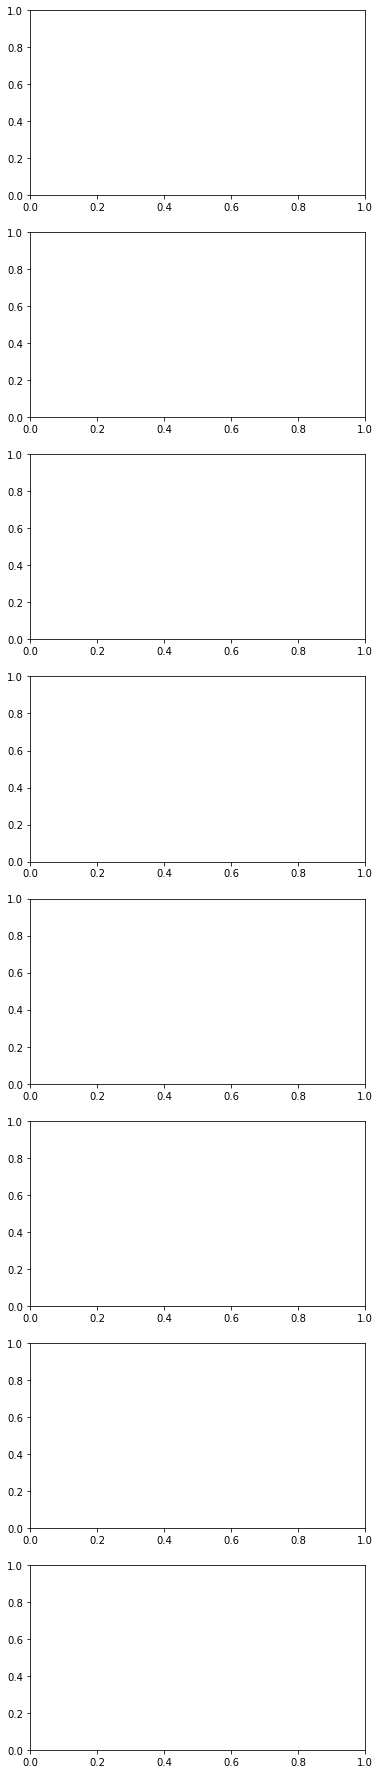

In [9]:
# sensitivity plot
#fig = plt.figure(figsize=(6,4),dpi=200)
f = np.logspace(-5,0,1000)
fig,axs=plt.subplots(len(missions),figsize=(6,4*len(missions)))
for i,mission in enumerate(missions):
    ax = axs[i]
    for ob in mission['obs']:
        if ob['source']['type']=='CW':continue
        if ob['assessment'].get('eps',10)>1:continue
        print(ob.get('f'))
        ax.plot(ob.get('f')[1:],np.abs(ob.get('h')[1:]**2)*np.diff(ob.get('f')),linestyle='-',label=ob.get('source').get('label'))
    
    ax.plot(f,metrics.makeSensitivity(f,mission),color = 'black', linewidth=2.0,linestyle='--',label='sensitivity')
    ax.set_title(mission['label'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)

plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Strain PSD [Hz$^{-1}$]')
plt.subplots_adjust()
plt.savefig('../plots/%s_source_sensitvities.png' % 'all')

#### SNR as a function of time plot

In [ ]:
# SNR of time plot
fig = plt.figure(figsize=(6,4),dpi=200)
#ax = fig.add_subplot(1,1,1)
fig,axs=plt.subplots(len(missions),figsize=(6,4*len(missions)))
for i,mission in enumerate(missions):
    ax = axs[i]
    for ob in mission['obs']:
        if ob['source']['type']=='CW':continue
        if ob['assessment'].get('eps',10)>1:continue
        print(mission['label'])
        print('snr',ob.get('SNR of t'))
        print('t',ob.get('t'))
        ax.plot(-ob.get('t')*52/constants.year,ob.get('SNR of t'),linestyle='-',label=ob.get('source').get('label'))
        ax.set_title(mission['label'])
        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.legend()
        
#print(obs)
#plt.xlim([-ob.get('t')[0]*52/constants.year+4,-4])
#plt.title(ob.get('source').get('label'))
plt.xlabel('Time to merger [wks]')
plt.ylabel(r'SNR')
plt.subplots_adjust()
#plt.legend()
ax.grid(True)
#plt.savefig('../plots/%s_snr_v_t.png' % modelName)

#### Angular resolution as a function of time

In [ ]:
# Angular resolution
# SNR of time plot
fig = plt.figure(figsize=(6,4),dpi=200)
#ax = fig.add_subplot(1,1,1)
fig,axs=plt.subplots(len(missions),figsize=(6,4*len(missions)))
for i,mission in enumerate(missions):
    ax = axs[i]
    for ob in mission['obs']:
        if ob['source']['type']=='CW':continue
        if ob['assessment'].get('eps',10)>1:continue
        ax.plot(-ob.get('t')*52/constants.year,ob.get('Angular Resolution of t')*1e3,label= ob.get('source').get('label'))
        ax.set_title(mission['label'])
        ax.set_xscale('linear')
        ax.set_yscale('log')
        plt.ylabel('Astrometric Precision [mrad]')
        ax.legend()
        
plt.xlabel('Time to merger [wks]')
plt.subplots_adjust()